In [1]:
#TODO Main Tasks
# Running NOW: Retrain only with ReLU and verify with Marabou


# Use Marabou to verify global robustness or areas of local robustness if the global robustness doesn't work.
# The network doesn't take time series as input, so time series input analysis seems like it's unrelated to this project
# but we can come up with something.

In [1]:
import matplotlib
#matplotlib.use('Agg') # If we don't want saved images printed on output

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import time

from Models.loss import smoothL1

from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Input, InputLayer
from tensorflow.keras.layers import Activation, Flatten, BatchNormalization
from tensorflow.keras.regularizers import l2

from sklearn import tree
from tqdm import tqdm
from collections import namedtuple
from io import StringIO
from io import BytesIO
import PIL.Image
from IPython.display import clear_output, Image, display, HTML
from NNet.python.nnet import NNet

import math
import io
import os
import sys
import operator
import copy
import glob

#from python.nnet import NNet


#from vis.visualization import visualize_cam
#import cv2
#FIXIT Needs old Scipy version (1.1.0), need to check integration with Conda and Pip

#import tensorflow as tf
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior() 

In [2]:
from tf_keras_vis.utils import num_of_gpus

from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize

from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.gradcam import GradcamPlusPlus

_, gpus = num_of_gpus()
print('{} GPUs'.format(gpus))

3 GPUs


## Loading the Data and Model

In [3]:
PLOT_DATA_BOEING = False
PLOT_DATA_KJ = True

BOEING_TRAIN = False 
BOEING_TEST = False

KJ_TRAIN = False
KJ_TEST  = True

In [4]:
## Loading the data
eval_folder = '../20200630_TaxiNet_data/'
eval_folder_kjtrain = '/home/ikadron/Work/KJ-TaxinetArtifacts/data_train/'
eval_folder_kjtest = '/home/ikadron/Work/KJ-TaxinetArtifacts/data_val/'

#Loading the data
if BOEING_TRAIN and not BOEING_TEST and not KJ_TRAIN and not KJ_TEST:
    x=np.load(eval_folder+'X_train.npy')
    y=np.load(eval_folder+'Y_train.npy')
elif BOEING_TEST and not BOEING_TRAIN and not KJ_TRAIN and not KJ_TEST:
    x=np.load(eval_folder+'X_test.npy')
    y=np.load(eval_folder+'Y_test.npy')
elif KJ_TRAIN and not BOEING_TEST and not BOEING_TRAIN and not KJ_TEST:
    eval_folder = '/home/ikadron/Work/KJ-TaxinetArtifacts/data_train/'
elif KJ_TEST and not BOEING_TEST and not BOEING_TRAIN and not KJ_TRAIN:
    eval_folder = '/home/ikadron/Work/KJ-TaxinetArtifacts/data_val/'
else:
    print("Only one of BOEING_TRAIN, BOEING_TEST, KJ_TRAIN, KJ_TEST has to be True.")
    
if KJ_TRAIN or KJ_TEST:
    table = pd.read_csv(eval_folder + "errors.csv")
    
    # Use each example image in folder
    exampleImages = glob.glob(eval_folder + "*png")
    imgNums = sorted([int( f.split("/")[-1].split(".")[0] ) for f in exampleImages])
    
    x = list()
    y = list()
    for imgNum in imgNums:
        img = PIL.Image.open("{}{}.png".format(eval_folder,imgNum))
        img_copy = np.array(img)
        truth = np.array([table.CTE[imgNum],table.HE[imgNum]])
        img.close()
        
        #print(img_copy.shape)
        x.append(img_copy)
        y.append(truth)
        
    
    x = np.array(x)
    y = np.array(y)

print("Shape of X:", x.shape)

Shape of X: (7386, 200, 360, 3)


In [5]:
# ##Loading the model
# #if MODEL == 'SimpleModel':
#     model_path = './Training_Runs/TaxiNet-Simple/SimpleModel.h5'
# elif MODEL == 'MobileNetModel':
#     model_path = './Training_Runs/TaxiNet-MobileNet/MobileNetV2.h5'
# else:
#     model_path = './Training_Runs/TaxiNet-FullyConnected/FullyConnectedModel.h5'

# print('Loading the model and printing the summary:')
# model=load_model(model_path,custom_objects={'smoothL1':smoothL1}) 

# model.summary()

### Testing Inputs with Boeing-TaxiNet

In [6]:
# Plots and graphs of distribution of outputs
if PLOT_DATA_BOEING:
    outputs_test   = []
    inference_time = []


    for img in x:
        t=time.time()
        outputs_test.append(model.predict(np.expand_dims(img/255.0,axis=0)))
        inference_time.append((1/(time.time()-t)))

    outputs_test=np.squeeze(np.asarray(outputs_test))
    inference_time=np.squeeze(np.asarray(inference_time))


    #Scale the predictions
    outputs_cte=outputs_test[:,0]*8.0
    outputs_heading=outputs_test[:,1]*35.0

    #Plot the predictions vs truth
    plt.figure()
    truth,=plt.plot(y[:,0],label='Truth')
    predictions,=plt.plot(outputs_cte,label='Predictions')
    plt.legend(handles=[truth,predictions])
    plt.title('Cross Track Error')
    plt.xlabel('sample number')
    plt.ylabel('distance in meters')
    plt.show()

    #Plot the model error histogram
    error_test=np.squeeze(y[:,0])-outputs_cte
    plt.figure()
    plt.hist(error_test,bins=50)
    plt.title('CT Error Histogram')
    plt.xlabel('Error in meters')
    plt.ylabel('number of instances')
    plt.show()

    #Plot the inference time histogram
    plt.figure()
    plt.hist(inference_time[1:],bins=50)
    plt.title('Inference Time Histogram')
    plt.xlabel('Inference Time in Hz')
    plt.ylabel('number of instances')
    plt.show()

    #Print error metrics
    print(" ")
    print("Cross Track Error")
    abs_error_test=np.abs(error_test)
    print('MeanAbsoluteError: '+str(np.mean(abs_error_test)))
    print('MedianAbsoluteError: '+str(np.median(abs_error_test)))
    print('StandardDeviation: '+str(np.std(abs_error_test)))
    print('MeanInferenceTime: '+str(np.mean(inference_time)))
    print('MaxAbsoluteError: '+str(np.max(abs_error_test)))

    #Plot the predictions vs truth
    plt.figure()
    truth,=plt.plot(y[:,1],label='Truth')
    predictions,=plt.plot(outputs_heading,label='Predictions')
    plt.legend(handles=[truth,predictions])
    plt.title('Heading Error')
    plt.xlabel('sample number')
    plt.ylabel('degrees')
    plt.show()

    #Plot the model error histogram
    error_test=np.squeeze(y[:,1])-outputs_heading
    plt.figure()
    plt.hist(error_test,bins=50)
    plt.title('Heading Error Histogram')
    plt.xlabel('Error in degrees')
    plt.ylabel('number of instances')
    plt.show()

    print(" ")
    print("Heading Error")
    #Print error metrics
    abs_error_test=np.abs(error_test)
    print('MeanAbsoluteError: '+str(np.mean(abs_error_test)))
    print('MedianAbsoluteError: '+str(np.median(abs_error_test)))
    print('StandardDeviation: '+str(np.std(abs_error_test)))
    print('MaxAbsoluteError: '+str(np.max(abs_error_test)))

### Testing Inputs with KJ-TaxiNet

In [7]:
def downsampleImage(img): 
    """
    Function for downsampling images of taxiway from 200x360x3 into 8x16x1
    """
    
    img = np.array(img)
    
    # Remove yellow/orange lines
    mask = ((img[:,:,0].astype('float')-img[:,:,2].astype('float'))>60) & ((img[:,:,1].astype('float')-img[:,:,2].astype('float'))>30) 
    img[mask] = 0
    
    # Convert to grayscale, crop out nose, sky, bottom of image, resize to 256x128, scale so 
    # values range between 0 and 1
    img = np.array(PIL.Image.fromarray(img).convert('L').crop((55,5,360,140)).resize((256,128)))/255.0

    # Downsample image
    # Split image into stride x stride boxes, average numPix brightest pixels in that box
    # As a result, img2 has one value for every box
    img2 = np.zeros((height,width))
    for i in range(height):
        for j in range(width):
            img2[i,j] = np.mean(np.sort(img[stride*i:stride*(i+1),stride*j:stride*(j+1)].reshape(-1))[-numPix:])

    # Ensure that the mean of the image is 0.5 and that values range between 0 and 1
    # The training data only contains images from sunny, 9am conditions.
    # Biasing the image helps the network generalize to different lighting conditions (cloudy, noon, etc)
    img2 -= img2.mean()
    img2 += 0.5
    img2[img2>1] = 1
    img2[img2<0] = 0
    return img2

if PLOT_DATA_KJ:
    
    ### IMPORTANT PARAMETERS FOR IMAGE PROCESSING ###
    stride = 16             # Size of square of pixels downsampled to one grayscale value
    numPix = 16             # During downsampling, average the numPix brightest pixels in each square
    width  = 256//stride    # Width of downsampled grayscale image
    height = 128//stride    # Height of downsampled grayscale image
    #################################################
    
    
    # Load network and ground truth errors table
    nnet = NNet("KJ_TaxiNet.nnet")
    table = pd.read_csv("errors.csv")

    # Use each example image in folder
    #exampleImages = glob.glob("*png")
    #imgNums = sorted([int(file.split(".")[0]) for file in exampleImages])
    #for imgNum in imgNums:

    error_test_ct = []
    error_test_he = []

    for imgNum, img in enumerate(x[:20]):

        # Load image
        #img = Image.open("%d.png" % imgNum)

        #print("Image shape:", img.shape)
        
        # Compute downsampled image to use as network input
        dsImg = downsampleImage(img)
        flatImg = dsImg.reshape(-1)
        
        #print("Downsampled Image shape:", dsImg.shape)
        #print("Flat Image shape:", flatImg.shape)

        # save dsImg
        #np.save("%d.npy" % imgNum, dsImg)

        # Compute prediction and ground truth of CTE / HE
        predictions = nnet.evaluate_network(dsImg.reshape(-1))
        #truth = np.array([table.CTE[imgNum], table.HE[imgNum]])
        truth = y[imgNum]

        error_test_ct.append(predictions[0]-truth[0])
        error_test_he.append( predictions[1]-truth[1])

        # Print result
        if False:
            print("\nImg Number: %d" % imgNum)
            print("Prediction: %.3f CTE, %.3f HE" % (predictions[0],predictions[1]))
            print("Truth: %.3f CTE, %.3f HE" % (truth[0],truth[1]))


    print(" ")
    print("Cross Track Error")
    abs_error_test=np.abs(error_test_ct)
    print('MeanAbsoluteError: '+str(np.mean(abs_error_test)))
    print('MedianAbsoluteError: '+str(np.median(abs_error_test)))
    print('StandardDeviation: '+str(np.std(abs_error_test)))
    print('MaxAbsoluteError: '+str(np.max(abs_error_test)))

    print(" ")
    print("Heading Error")
    abs_error_test=np.abs(error_test_he)
    print('MeanAbsoluteError: '+str(np.mean(abs_error_test)))
    print('MedianAbsoluteError: '+str(np.median(abs_error_test)))
    print('StandardDeviation: '+str(np.std(abs_error_test)))
    print('MaxAbsoluteError: '+str(np.max(abs_error_test)))

 
Cross Track Error
MeanAbsoluteError: 1.2301886719867832
MedianAbsoluteError: 1.1476284667313994
StandardDeviation: 0.328541700345444
MaxAbsoluteError: 1.7994767347303364
 
Heading Error
MeanAbsoluteError: 2.696643050193012
MedianAbsoluteError: 2.7565213364950876
StandardDeviation: 1.0198928500674072
MaxAbsoluteError: 4.221397363510208


In [8]:
KJ_TAXINET_TRANSFER = True

if KJ_TAXINET_TRANSFER:
    #Using Keras to Load KJ-TaxiNet
    model = Sequential()
    for ind, layer_size in enumerate(nnet.layerSizes[1:-1]):
        print(layer_size)
        if ind == 0:
            model.add(Dense(layer_size, activation='relu', kernel_initializer='he_normal', input_shape=(128,), name='dense_{}'.format(ind+1)))
        else:
            model.add(Dense(layer_size, activation='relu', kernel_initializer='he_normal', name='dense_{}'.format(ind+1)))
    model.add(Dense(2,kernel_initializer='he_normal', name='dense_4'))

    model.summary()

16
8
8
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                2064      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 18        
Total params: 2,290
Trainable params: 2,290
Non-trainable params: 0
_________________________________________________________________


In [9]:
#Transferred KJ-TaxiNet to Keras!
if KJ_TAXINET_TRANSFER:
    layer_name_list = ['dense_1', 'dense_2', 'dense_3', 'dense_4']

    print(nnet.numLayers)
    print(nnet.layerSizes)
    #print(nnet.ranges)
    #print(nnet.means)

    for ind, layer_name in enumerate(layer_name_list):
        temp = model.get_layer(layer_name).get_weights()

        l_w = np.transpose(np.array(nnet.weights[ind]))
        l_b = np.array(nnet.biases[ind])

        #print(type(temp))
        #print(temp[0].shape)
        #print(temp[1].shape)
        #print(l_w.shape)
        #print(l_b.shape)

        model.get_layer(layer_name).set_weights([l_w, l_b])

    ### IMPORTANT PARAMETERS FOR IMAGE PROCESSING ###
    stride = 16             # Size of square of pixels downsampled to one grayscale value
    numPix = 16             # During downsampling, average the numPix brightest pixels in each square
    width  = 256//stride    # Width of downsampled grayscale image
    height = 128//stride    # Height of downsampled grayscale image
    #################################################


    # Load network and ground truth errors table
    #nnet = NNet("KJ_TaxiNet.nnet")
    #table = pd.read_csv("errors.csv")

    # Use each example image in folder
    #exampleImages = glob.glob("*png")
    #imgNums = sorted([int(file.split(".")[0]) for file in exampleImages])
    #for imgNum in imgNums:

    error_test_ct = []
    error_test_he = []
    
    error_diff_ct = []
    error_diff_he = []

    for imgNum, img in enumerate(x):

        # Load image
        #img = Image.open("%d.png" % imgNum)

        # Compute downsampled image to use as network input
        dsImg = downsampleImage(img)

        # save dsImg
        #np.save("%d.npy" % imgNum, dsImg)

        # Compute prediction and ground truth of CTE / HE
        flat_img = dsImg.reshape(-1)
        flat_img_keras = np.expand_dims(flat_img, axis=0)
        #print("Flat Img Shape:", flat_img.shape)
        #print("Flat Img Keras Shape:", flat_img_keras.shape)
        #print("Img Shape:", x[0].shape)
        predictions1 = nnet.evaluate_network(flat_img)
        predictions2 = model.predict(flat_img_keras)

        #outputs_test=np.squeeze(np.asarray(outputs_test))
        #inference_time=np.squeeze(np.asarray(inference_time))

        #truth = np.array([table.CTE[imgNum], table.HE[imgNum]])
        truth = y[imgNum]

        error_test_ct.append(predictions1[0]-truth[0])
        error_test_he.append(predictions1[1]-truth[1])
        
        error_diff_ct.append(predictions1[0]-predictions2[0][0])
        error_diff_he.append(predictions1[0]-predictions2[0][0])

        # Print result
        if (predictions1[0] - predictions2[0][0] > 0.1):
            print("\nImg Number: %d" % imgNum)
            print("Prediction NNet: %.3f CTE, %.3f HE" % (predictions1[0],predictions1[1]))
            print("Prediction Keras: %.3f CTE, %.3f HE" % (predictions2[0][0],predictions2[0][1]))
            print("Truth: %.3f CTE, %.3f HE" % (truth[0],truth[1]))


            
    abs_error_diff_ct = np.abs(error_diff_ct)
    print('MeanAbsoluteDifference CTE: '+str(np.mean(abs_error_diff_ct)))
    abs_error_diff_he = np.abs(error_diff_he)
    print('MeanAbsoluteDifference HE: '+str(np.mean(abs_error_diff_he)))
    
    print(" ")
    print("Cross Track Error")
    abs_error_test=np.abs(error_test_ct)
    print('MeanAbsoluteError: '+str(np.mean(abs_error_test)))
    print('MedianAbsoluteError: '+str(np.median(abs_error_test)))
    print('StandardDeviation: '+str(np.std(abs_error_test)))
    print('MaxAbsoluteError: '+str(np.max(abs_error_test)))

    print(" ")
    print("Heading Error")
    abs_error_test=np.abs(error_test_he)
    print('MeanAbsoluteError: '+str(np.mean(abs_error_test)))
    print('MedianAbsoluteError: '+str(np.median(abs_error_test)))
    print('StandardDeviation: '+str(np.std(abs_error_test)))
    print('MaxAbsoluteError: '+str(np.max(abs_error_test)))


    #print(len(nnet.weights))
    #print(len(nnet.weights[0]))
    #print(len(nnet.weights[0][0]))
    #print(len(nnet.weights[1]))
    #print(len(nnet.biases[0]))


4
[128, 16, 8, 8, 2]
MeanAbsoluteDifference CTE: 2.6061404519667714e-06
MeanAbsoluteDifference HE: 2.6061404519667714e-06
 
Cross Track Error
MeanAbsoluteError: 1.435996198475685
MedianAbsoluteError: 1.2262143001819321
StandardDeviation: 1.0665681338567263
MaxAbsoluteError: 9.604651518062415
 
Heading Error
MeanAbsoluteError: 2.751920598503374
MedianAbsoluteError: 2.30513006969154
StandardDeviation: 2.360128109920573
MaxAbsoluteError: 24.663136410407308


In [10]:
#Extracting activations for each layer

#for layer_name in ['dense_1']: #['dense_1', 'dense_2', 'dense_3']:
#    print('Extracting values for layer {}'.format(layer_name))
#    intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
#    #intermediate_output = intermediate_layer_model.predict(data)
#    
#    layers_test  = []
#    outputs_test = []
#    
#    for img in x:
#        t=time.time()
#        layer_result = (intermediate_layer_model.predict(np.expand_dims(img/255.0,axis=0))>0).astype('int')
#        #print(layer_result[0])
#        layers_test.append(layer_result[0])
#        outputs_test.append(model.predict(np.expand_dims(img/255.0,axis=0)))
#        
#    layers_test = np.asarray(layers_test)
#    
#    #Scale the predictions
#    outputs_test = np.squeeze(np.asarray(outputs_test))
#    outputs_cte = outputs_test[:,0]*8.0
#    outputs_heading = outputs_test[:,1]*35.0
#    outputs_cte_divided = (outputs_cte>0).astype('int')
#    outputs_heading_divided = (outputs_heading>0).astype('int')
#    print("Cross Track Error: {}".format(outputs_cte))
#    print("Heading Error: {}".format(outputs_heading))
#    
#    print("Layer patterns: {}".format(layers_test))
#    print("Cross Track Error Divided: {}".format(outputs_cte_divided))
#    print("Heading Error Divided: {}".format(outputs_heading_divided))

In [11]:
# CROSS TRACK ERROR PREDICTION DIVISIONS:
# Change it so that instead of Positive or Negative prediction the classes should be following:
# Absolute error is between 0 to 2.0 (|Prediction - Ground Truth|)
# Absolute error is greater than 2.0
#----------------------------------------------------------------------------------------------
# Combine both positive/negative prediction and error bound is within 1.5/greater than 1.5
# OR Ground truth is positive/negative and error bound is within 1.5/greater than 1.5

# HEADING ERROR PREDICTION DIVISIONS:
# 
def get_prediction(inputs, tensor = None):
    if tensor == "ALL":
        full_list = []
        for tensor in ['dense_1', 'dense_2', 'dense_3']:
            layer_name = tensor
            layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
            layer_outputs_test = []
            for img in inputs:
                dsImg = downsampleImage(img)
                flat_img = dsImg.reshape(-1)
                flat_img_keras = np.expand_dims(flat_img, axis=0)

                layer_result = (layer_model.predict(flat_img_keras)>0).astype('int')
                #layer_output = layer_model.predict(np.expand_dims(img/255.0,axis=0))[0]
                layer_outputs_test.append(layer_result[0])
            full_list.append(layer_outputs_test)
        
        new_list = [list(full_list[0][i])+list(full_list[1][i])+list(full_list[2][i]) for i in range(len(inputs))]
            
        layer_outputs_test = np.asarray(new_list)
        return layer_outputs_test
    if tensor is None or tensor == 'dense_4':
        outputs_test = []
        
        for img in inputs:
            dsImg = downsampleImage(img)
            flat_img = dsImg.reshape(-1)
            flat_img_keras = np.expand_dims(flat_img, axis=0)
            
            outputs_test.append(model.predict(flat_img_keras))

        outputs_test    = np.squeeze(np.asarray(outputs_test))

        #Scale the predictions
        outputs_cte     = outputs_test[:,0]
        outputs_heading = outputs_test[:,1]
        
        #Absolute value of the predictions
        abs_outputs_cte = np.abs(outputs_cte)
        abs_outputs_heading = np.abs(outputs_heading)
        
        #Absolute Error between Ground Truth and Prediction for Cross Track Error
        error_cte=np.squeeze(y[:inputs.shape[0],0])-outputs_cte
        abs_error_cte=np.abs(error_cte)

        #Absolute Error between Ground Truth and Prediction for Heading Error
        error_heading     = np.squeeze(y[:inputs.shape[0],1])-outputs_heading
        abs_error_heading = np.abs(error_heading)
        
        #return (abs_error_heading<=10.0).astype('int')
        return abs_outputs_heading, (abs_outputs_cte<=10.0).astype('int')
        #return ((outputs_cte>0).__and__(outputs_cte<=1.0)).astype('int')
    else:
        layer_name = tensor
        layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
        layer_outputs_test = []
        for img in inputs:
            dsImg = downsampleImage(img)
            flat_img = dsImg.reshape(-1)
            flat_img_keras = np.expand_dims(flat_img, axis=0)
            
            layer_result = (layer_model.predict(flat_img_keras)>0).astype('int')
            #layer_output = layer_model.predict(np.expand_dims(img/255.0,axis=0))[0]
            layer_outputs_test.append(layer_result[0])

        layer_outputs_test = np.asarray(layer_outputs_test)

        #Scale the predictions        
        return layer_outputs_test

def fingerprint_suffix(inps,ten):
    return (get_prediction(inps, tensor=ten)>0.0).astype('int')

def fingerprint_signature(inps, layer_name = 'dense_1'):
    return None
#    layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
#    layer_result = (layer_model.predict(np.expand_dims(img/255.0,axis=0))>0).astype('int')[0]
#    return layer_result

In [12]:
# The `output` variable refer to the output of the model,
# so, in this case, `output` shape is `(1, 2)` i.e., (samples, classes).

#Loss and Model Modifier for middle layers
def loss_gen_sum(node_list):
    def loss(output):
        loss_val = sum([output[0][i] for i in node_list])/len(node_list)
        return loss_val
    return loss

def loss_gen_separate(node_list):
    def loss(output):
        loss_val = tuple([output[ind][i] for ind,i in enumerate(node_list)])
        return loss_val
    return loss

def model_modifier(current_model):
    target_layer = current_model.get_layer(name=layer)
    new_model = tf.keras.Model(inputs=current_model.inputs,
                               outputs=target_layer.output)
    new_model.layers[-1].activation = tf.keras.activations.linear
    return new_model
    
def loss_crosstrack(output):
    return (output[0][0])

def loss_heading(output):
    return (output[0][1])

def no_loss(output):
    return (output[0][0] * 0)

def model_modifier_lastlayer(m):
    m.layers[-1].activation = tf.keras.activations.linear
    return m

In [13]:
def get_decision_path(estimator, inp):
  # Extract the decision path taken by an input as an ordered list of indices
  # of the neurons that were evaluated.
  # See: http://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html
  n_nodes = estimator.tree_.node_count
  feature = estimator.tree_.feature

  # First let's retrieve the decision path of each sample. The decision_path
  # method allows to retrieve the node indicator functions. A non zero element of
  # indicator matrix at the position (i, j) indicates that the sample i goes
  # through the node j.
  X_test = [inp]
  node_indicator = estimator.decision_path(X_test)
  # Similarly, we can also have the leaves ids reached by each sample.
  leaf_id = estimator.apply(X_test)
  # Now, it's possible to get the tests that were used to predict a sample or
  # a group of samples. First, let's make it for the sample.
  node_index = node_indicator.indices[node_indicator.indptr[0]:
                                      node_indicator.indptr[1]]
  neuron_ids = []
  for node_id in node_index:
    if leaf_id[0] == node_id:
        continue
    neuron_ids.append(feature[node_id])
  return neuron_ids

def get_suffix_cluster(neuron_ids, neuron_sig,suffixes):
  # Get the cluster of inputs that such that all inputs in the cluster
  # have provided on/off signature for the provided neurons.
  #
  # The returned cluster is an array of indices (into mnist.train.images).
  return np.where((suffixes[:, neuron_ids] == neuron_sig).all(axis=1))[0]

def is_consistent_cluster(cluster, predictions):
  # Check if all inputs within the cluster have the same prediction.
  # 'cluster' is an array of input ids.
  pred = predictions[cluster[0]]
  for i in cluster:
    if predictions[i] != pred:
      return False
  return True

def is_misclassified(i):
  #print(train_predictions[i])
  #print(y[i][0])
  return False
  #return (1 if train_predictions[i]>0.0 else 0) != (1 if y[i][0]>0.0 else 0)

def visualize_conductances(img, label, layer, neuron_ids, only_on=False):
  # Visualize the conductances for the provided image.
  # Args:
  # - img: the provided mnist image
  # - label: prediction label w.r.t. conductance must be computed
  # - neuron_ids: list of neurons indices from the suffix tensor for which
  #    conductances must be computed.
  # - only_on: If True then conductance is computed only for those neurons
  #    that are on for the given image. 
  vis = [mnist_to_pil_img(img)]
  suffix = fingerprint_suffix([img], layer)
  sumigc = 0.0
  for i, id in enumerate(neuron_ids):
    if only_on and suffix[i] != 1:
      continue  
    igc = conductance(img, label, neuron_id=id)
    # igc = conductances[id]
    sumigc = sumigc + igc
  
  
  avgigc = sumigc / len(neuron_ids)
  maxval = abs(max(avgigc, key=abs))
  minval = abs(min(avgigc, key=abs))
  threshold = (maxval - minval)/2.0
  print("MAX ATR:", maxval, "MIN ATR:", minval, "THRESH:", threshold)
  avgigc = 1.0 * avgigc * (abs(avgigc) >= threshold)
  
  
  vis.append(visualize_attrs2(255*mnist_to_rgb(img), mnist_to_rgb(avgigc)))
  return combine(vis)

def get_invariant_inp(estimator, ref_id, suffixes):
  # Returns an invariant found w.r.t. the provided reference input
  # Args
  #  - inp: reference input, shape <784,>
  # Returns:
  #  - cluster: Indices of training inputs that satisfy the invariant
  #  - neuron_id: A list of neurons such that all inputs that agree with
  #    the reference input on the on/off status of these neurons have the
  #    same prediction as the reference input.
  ref_img = mnist_inp_images[ref_id]
  ref_suffix = suffixes[ref_id]
  print('PREFIX',ref_suffix)
  neuron_ids = get_decision_path(estimator, ref_suffix)
  print('NEURON IDS',neuron_ids)
  neuron_sig = ref_suffix[neuron_ids]
  print('NEURON SIGNATURE',neuron_sig)
  cluster = get_suffix_cluster(neuron_ids, neuron_sig,suffixes)
  imgs = []
  cnt = 0
  for indx1 in range(0,len(cluster)):
    img = mnist.train.images(cluster[indx1])
    fnd = 1
    for i in range(0,len(img)):
      if (ref_img[i] != img[i]):
        fnd = 0
        break
    if (fnd == 1):
        ref_id = cnt
    cnt = cnt + 1
    imgs.append(img)
    
  imgs_suffixes = fingerprint_signature(imgs,'dense_1')
  ref_suffix = imgs_suffixes[ref_id]
  print('PREFIX',ref_suffix)
  neuron_ids = get_decision_path(estimator, ref_suffix)
  print('NEURON IDS',neuron_ids)
  neuron_sig = ref_suffix[neuron_ids]
  print('NEURON SIGNATURE',neuron_sig)
  cluster = get_suffix_cluster(neuron_ids, neuron_sig, imgs_suffixes)
    
  return cluster, neuron_ids, neuron_sig

def get_invariant(estimator, ref_id, suffixes):
  # Returns an invariant found w.r.t. the provided reference input
  # Args
  #  - ref_id: Index (into mnist.train.images) of the reference input
  # Returns:
  #  - cluster: Indices of training inputs that satisfy the invariant
  #  - neuron_id: A list of neurons such that all inputs that agree with
  #    the reference input on the on/off status of these neurons have the
  #    same prediction as the reference input.
  ref_img = mnist.train.images[ref_id]
  ref_suffix = suffixes[ref_id]
  neuron_ids = get_decision_path(estimator, ref_suffix)
  neuron_sig = ref_suffix[neuron_ids]
  cluster = get_suffix_cluster(neuron_ids, neuron_sig)
  return cluster, neuron_ids, neuron_sig


def get_all_invariants(estimator):
  # Returns a dictionary mapping each decision tree prediction class
  # to a list of invariants. Each invariant is specified as a triple:
  # - neuron ids
  # - neuron signature (for the neuron ids)
  # - number of training samples that hit it
  # The neuron ids and neuron signature can be supplied to get_suffix_cluster
  # to obtain the cluster of training instances that hit the invariant.
  def is_leaf(node):
    return estimator.tree_.children_left[node] == estimator.tree_.children_right[node]

  def left_child(node):
    return estimator.tree_.children_left[node]

  def right_child(node):
    return estimator.tree_.children_right[node]
  
  def get_all_paths_rec(node):
    # Returns a list of triples corresponding to paths
    # in the decision tree. Each triple consists of
    # - neurons encountered along the path
    # - signature along the path
    # - prediction class at the leaf
    # - number of training samples that hit the path
    # The prediction class and number of training samples
    # are set to -1 when the leaf is "impure".
    feature = estimator.tree_.feature
    if is_leaf(node):
      values = estimator.tree_.value[node][0]
      if len(np.where(values != 0)[0]) == 1:
        cl = estimator.classes_[np.where(values != 0)[0][0]]
        nsamples = estimator.tree_.n_node_samples[node]
      else:
        # impure node
        cl = -1
        nsamples = -1
      return [[[], [], cl, nsamples]]
    # If it is not a leaf both left and right childs must exist
    paths = [[[feature[node]] + p[0], [0] + p[1], p[2], p[3]] for p in get_all_paths_rec(left_child(node))]
    paths += [[[feature[node]] + p[0], [1] + p[1], p[2], p[3]] for p in get_all_paths_rec(right_child(node))]
    return paths
  paths =  get_all_paths_rec(0)
  print("Obtained all paths")
  invariants = {}
  for p in tqdm(paths):
    neuron_ids, neuron_sig, cl, nsamples = p
    if cl not in invariants:
      invariants[cl] = []
    # cluster = get_suffix_cluster(neuron_ids, neuron_sig)
    invariants[cl].append([neuron_ids, neuron_sig, nsamples])
  for cl in invariants.keys():
    invariants[cl] = sorted(invariants[cl], key=operator.itemgetter(2), reverse=True)
  return invariants


def describe_cluster(cluster, neuron_ids, suffixes, show_samples=False):
  neuron_sig = suffixes[cluster[0]][neuron_ids]
  print("Num neurons in invariant", len(neuron_ids))
  print("Neuron id and signature")
  
  for i in range(0,len(neuron_ids)):
    print("id:", neuron_ids[i], "sig:", neuron_sig[i])
  
  print("Cluster size: ", len(cluster))
  print("Num misclassified", len([i for i in cluster if is_misclassified(i)]))
  if show_samples:
    for i in range(10):
      images = []
      for j in range(10):
        if 10*i + j >= len(cluster):
          break
        images.append(mnist_to_pil_img(mnist.train.images[cluster[10*i+j]]))
      if len(images) > 0:
        show_img(combine(images))
  

def describe_invariants_all_labels(all_invariants,prevlayer,layer,suffixes, COMMON=False, DEC_PREFX= False):
  print("PRINTING PURE RULES WITH SUPPORT MORE THAN 1000 FOR EVERY LABEL:");
  for cl, invs in all_invariants.items():
    if (cl == -1):
      continue
    
    for indx in range (0, 5):
    #len(invs)):
      inv = invs[indx]
      cls = get_suffix_cluster(inv[0],inv[1],suffixes)
      
      neurons = inv[0]
      signature = inv[1]

      if (len(cls) <= 1000):
        continue
      print("Class:", cl, ", Rule:(neurons:",inv[0],",signature:",inv[1],"), Support:",inv[2],", Num misclassified", len([i for i in cls if is_misclassified(i)]));

      ##invoke_marabou_chk(LAYER,neurons,signature,cl)

      if (COMMON == True):
          common_nodes(cls,suffixes)

      if (DEC_PREFX == True):
          decision_prefs(cls,suffixes)

  return
  
def common_nodes(cls,suffixes):
    cnt = 0
    common = np.zeros(10,dtype=int)
    prev = np.zeros(10,dtype=int)
    
    for indx in range(0, len(cls)):
        i = cls[indx]
        cnt = cnt + 1
        for j in range(0,len(suffixes[i])):
          if (common[j] == -1):
             continue
          if ((indx != 0) and (suffixes[i][j] != prev[j])):
             common[j] = -1
          else:
             common[j] = suffixes[i][j]
          prev[j] = suffixes[i][j]


    print('COMMON NODES IN CLUSTER for CLASS:',cl,cnt)
    com = []
    for k in range(0,len(common)):
        if (common[k] != -1):
           com.append((k,common[k]))
    print(com)

    return
    
def decision_prefs(cls,suffixes):
    images = mnist.train.images
    imgsCom = []
    imgs = []
    for indx in range(0, len(cls)):
        print('IMG:')
        print(list(zip(images[cls[indx]])))
        imgs.append(images[cls[indx]])
        imgsCom.append(images[cls[indx]])
            
    dec_prefixes= fingerprint_signature(imgs,layer)
    prefixes = []
    for indx in range(0,len(dec_prefixes)):
       dec_pref = dec_prefixes[indx]
    
       match = 0
       for indx1 in range(0, len(prefixes)):
          match = 1
          for i in range(0,len(prefixes[indx1])):
             if (dec_pref[i] != prefixes[indx1][i]):
                match = 0
                break
          if (match == 1):
             break
    
       if (match == 0):
          prefixes.append(dec_pref)
    
    print('DECISION PREFIXES IN CLUSTER for CLASS:',cl,cnt)
    for k in range(0,len(prefixes)):
      print(prefixes[k])

    return
    
  
  #print('LAYER INPS:')
  #min = np.zeros(10)
  #max = np.zeros(10)
  #for dim in range(0,10):
  #    min[dim] = 1000
  #    max[dim] = -1000
          
  #prevlayer_vals = get_prediction(imgsCom,prevlayer)      
  #print('MIN, MAX LAYER INPS:',len(prevlayer_vals))
  #for i in range(0,len(prevlayer_vals)):
  #    if (i == 0):
  #      print(zip(prevlayer_vals[i]))
  #    for dim in range(0,10):
  #        if ( prevlayer_vals[i][dim] < min[dim]):
  #            min[dim] = prevlayer_vals[i][dim]
  #        if ( prevlayer_vals[i][dim] > max[dim]):
  #            max[dim] = prevlayer_vals[i][dim]
    
  #print('MIN')
  #print(zip(min))
  #print('MAX')
  #print(zip(max))    
    
  #df = pd.DataFrame(df, columns=['Prediction Class', 'Num Instances', 'Num Invariants', 'Num Invariants with cluster size >= 10', 'Size of largest invariant cluster'])
  #df = pd.DataFrame(df,columns=['Pred Class','Total #Neurons','# Invariants'])
  #return df


def describe_all_invariants(all_invariants):
  df = []
  for cl, invs in all_invariants.iteritems(): 
    inv = invs[0]
    clus = get_suffix_cluster(inv[0],inv[1])
    #print(len(clus))
    misCl = 0
    for i in range(0,len(clus)):
      indx = clus[i]
      if (is_misclassified(indx) == True):
        misCl = misCl + 1
    print('class:',cl,',masSup:',inv[2],',#misCl:',misCl)
          

In [14]:
# print(x.shape)
# print(len(train_suffixes))
# print(len(train_predictions))
# print(train_suffixes[0])
# print(train_predictions[0])
# print(sum(train_predictions))
# basic_estimator.max_features_

In [24]:
actual_predictions, train_predictions = get_prediction(x[:100])#x[:int(len(x)/2)])
print("Predictions computed for all training data")

Predictions computed for all training data


In [25]:
#print(sum((actual_predictions<=20.0).astype('int')))

In [26]:
LAYER = 4
if LAYER == 1:
    layer = 'dense_1' #16
elif LAYER == 2:
    layer = 'dense_2' #8
elif LAYER == 3:
    layer = 'dense_3' #8
else:
    layer = 'ALL'

In [27]:
train_suffixes = fingerprint_suffix(x[:100], layer) #[:int(len(x)/2)], layer)
print("Suffixes computed for all training data")


Suffixes computed for all training data


In [28]:
# Basic decision tree
basic_estimator = tree.DecisionTreeClassifier()
basic_estimator.fit(train_suffixes, train_predictions)

DecisionTreeClassifier()

In [29]:
import time

def invoke_marabou_chk(layer, neurons, signature, label, cl, x_min, x_max, y_min, y_max):
    subplot_args = {'subplot_kw': {'xticks': [], 'yticks': []} }# 'nrows': 1, 'ncols': 1, 'figsize': (6, 12),
    
    #layer = 1
    #neurons = [4, 8, 7, 1, 0, 2, 5, 3, 9, 6] 
    #signature = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    #label = 6

    #for lab_indx in range(0,10):
    #if (lab_indx == label):
    #  continue
    limit = 10.0
    not_done = False
    ROBUSTNESS = False

    print("there exists x: x >= x_min /\ x <= x_max /\ Rule /\ (y < y_min \/ y > y_max)")
    print("Needs to be UNSAT to prove Rule /\ x_bounding_box => (y_min <= y <= y_max)")
    
    strInternal = ""
    #Input constraints
    for i in range(len(x_min)):
        strInternal = strInternal + "x"+ str(i) + " >= " + str(x_min[i]) + "\n"
        strInternal = strInternal + "x"+ str(i) + " <= " + str(x_max[i]) + "\n"
    
    #Hidden layer constraints
    if layer == 'ALL':
        for i in range(0,len(neurons)):
            if neurons[i] < 16:
                strInternal = strInternal + "ws_1" + "_" + str(neurons[i])
            elif neurons[i] < 24:
                strInternal = strInternal + "ws_2" + "_" + str(neurons[i]-16)
            else:
                strInternal = strInternal + "ws_3" + "_" + str(neurons[i]-24)
                
            if (signature[i] == 0):
                strInternal = strInternal + " <= 0.0" + "\n"
            else:
                strInternal = strInternal + " >= 0.0"  + "\n"
    else:
        for i in range(0,len(neurons)):
            strInternal = strInternal + "ws_"+ str(layer[-1]) + "_" + str(neurons[i])
            if (signature[i] == 0):
                strInternal = strInternal + " <= 0.0" + "\n"
            else:
                strInternal = strInternal + " >= 0.0"  + "\n"

    strOP = ""
    #Output layer constraints
    if cl == 0:
        strOP = "y0 <= {}\ny0 >= {}\n".format(limit, -limit)
        ROBUSTNESS = False
    if cl == 1:
        y_max = limit
        y_min = -limit
    ROBUSTNESS = True    
        
    if ROBUSTNESS:
        print("Testing NOT(y_min <= y <= y_max)")
        print("Testing NOT({} <= y <= {})".format(y_min, y_max))
        for (op, val) in [('>=', y_max+0.1), ('<=', y_min-0.1)]:
            strOP = "y0 {} {}\n".format(op, val)

            #Write to a property file
            file1 = open('TaxiNetProperty.txt',"w")
            #file1.writelines(strInp) 
            file1.writelines(strInternal) 
            file1.writelines(strOP) 
            file1.close() 

            #    file1 = open('property.txt',"r")  
            #    print("PROPERTY FILE IS ")
            #    print(file1.read())
            #    file1.close()

            !MarabouExample/Marabou-nosbt ./KJ_TaxiNet.nnet ./TaxiNetProperty.txt --summary-file=TaxiNetSummary.txt --verbosity=0 > TaxiNetSummary2.txt #2>&1
            time.sleep(0.5)
            print("SUMMARY:")
            f = open('TaxiNetSummary.txt', 'r')
            file_contents = f.read()
            print(file_contents)
            f.close()
            if(file_contents.find('UNSAT') == -1):
                not_done = True
                image_vals = []
                f2 = open('TaxiNetSummary2.txt', 'r')
                file_contents = f2.readlines()
                #print(file_contents)
                for line in file_contents:
                    if "=" in line and "x" in line:
                        value = line.split("=")[-1]
                        #print("x", value)
                        #print("x", float(value))
                        image_vals.append(float(value))
                #print (file_contents)
                f2.close()
                img = np.array(image_vals)
                img = np.reshape(img, (8,16))
                img = np.rint(img*255.0)

                f, ax = plt.subplots(**subplot_args)

                #Visualize base image
                ax.imshow(img)
                ax.set_title("Counterexample Image", fontsize=14)
                plt.tight_layout()
                plt.show()
                plt.close(f)

    else:
        #Write to a property file
        file1 = open('TaxiNetProperty.txt',"w")
        #file1.writelines(strInp) 
        file1.writelines(strInternal) 
        file1.writelines(strOP) 
        file1.close() 

        #    file1 = open('property.txt',"r")  
        #    print("PROPERTY FILE IS ")
        #    print(file1.read())
        #    file1.close()

        !MarabouExample/Marabou-nosbt ./KJ_TaxiNet.nnet ./TaxiNetProperty.txt --summary-file=TaxiNetSummary.txt --verbosity=0 | tee TaxiNetSummary2.txt #2>&1
        time.sleep(0.5)
        print("SUMMARY:")
        f = open('TaxiNetSummary.txt', 'r')
        file_contents = f.read()
        print (file_contents)
        f.close()
        if (file_contents.find('UNSAT') == -1):
            not_done = True
        else:
            image_vals = []
            f2 = open('TaxiNetSummary2.txt', 'r')
            file_contents = f2.readlines()
            for line in file_contents:
                if "=" in line and "x" in line:
                    value = line.split("=")[-1]
                    print("x", value)
                    print("x", float(value))
                    image_vals.append(float(value))
            print (file_contents)
            f2.close()
            print("If the values are correct, visualize!")

    if (not_done == False):
        print("RULE PROVED TO BE A PROPERTY!")
        return True
    else:
        print ("PROPERTY COULD NOT BE PROVED:")
        return False
  
  #f.close()

In [30]:
def describe_invariants_all_labels(all_invariants,prevlayer,layer,suffixes,label):
    #base_image_folder = './Images/BaseImages/'
    #if not os.path.exists(base_image_folder):
    #    os.makedirs(base_image_folder)
    #image_folder = './Images/KJ_TaxiNet_CrossTrackBound_1'
    #if not os.path.exists(image_folder):
    #    os.makedirs(image_folder)
    plt.style.use('grayscale')
    
    VISUALIZE = False
    SAVE = False
    SHOW = True
    min_support = 1

    print("\n PRINTING PURE RULES WITH SUPPORT MORE THAN {}:".format(min_support));
    for cl, invs in all_invariants.items():
        #if ((cl == -1)): 
        #    continue
    
    
        for indx in range (0, len(invs)):
            inv = invs[indx]
            cls = get_suffix_cluster(inv[0],inv[1],suffixes)
      
            neurons = inv[0]
            signature = inv[1]
            print(len(cls))

            
            print("Class:", cl, ", Rule:(neurons:",inv[0],",signature:",inv[1],"), Support:",inv[2],", Num misclassified", len([i for i in cls if is_misclassified(i)]));
            
            
            if (len(cls) <= min_support):   
                continue
            if ((cl == -1)): 
                continue
                
            interval = int(len(cls)/10)
            
            #Finding Longest Sequences
            i = 0
            sequence = [cls[k] for k in range(len(cls))]
            #print("Image Sequence for Class:", sequence)
            sequence = sorted(sequence)
            #print("Sorted Image Sequence for Class:", sequence)
            cons_subsequence = []
            subseq_start = False
            new_subseq = []
            for el in sequence:
                if subseq_start is False or el == new_subseq[-1] + 1:
                    subseq_start = True
                else:
                    cons_subsequence.append(new_subseq)
                    new_subseq = []
                new_subseq.append(el)
            cons_subsequence.append(new_subseq)
            
            cons_subsequence = sorted(cons_subsequence, key=len)
            cons_subsequence.reverse()
            
            print("Consecutive Subsequence Lengths by decreasing length:", [len(el) for el in cons_subsequence])
            
            for sequence_ind, sequence in enumerate(cons_subsequence[0:10]):
                len_lower_limit = 1
                if len(sequence) <= len_lower_limit:
                    print("Skipping sequence {} because its length {} is less than or equal to {}".format(sequence_ind, len(sequence), len_lower_limit))
                    continue
                print("Generating images for sequence {} of length {}".format(sequence_ind, len(sequence)))

                heatmap_sequence = list()
                 
                test_img = x[sequence[0]]
                dsImg = downsampleImage(test_img)
                flat_img = dsImg.reshape(-1)
                #flat_img_keras = np.expand_dims(flat_img, axis=0)
                
                min_img = flat_img[:] #x[sequence[0]]
                max_img = flat_img[:] #x[sequence[0]]

                for ind, ref_id in enumerate(sequence):
                    if ind > 0:
                        img = x[ref_id]
                        dsImg = downsampleImage(img)
                        new_img = dsImg.reshape(-1)
                        min_img = np.minimum(min_img, new_img)
                        max_img = np.maximum(max_img, new_img)
                    
                    #Visualize base image
                    if ind%3 == 0 or ind == len(sequence)-1:
                        f, ax = plt.subplots(**{'subplot_kw': {'xticks': [], 'yticks': []}})
                        ax.imshow(dsImg)
                        ax.set_title("Downsampled Image #{}".format(ref_id), fontsize=14)
                        plt.tight_layout()
                        plt.show()
                        plt.close(f)
                        
                print("Generating proofs for sequence {} of length {}".format(sequence_ind, len(sequence)))
                    
                y_subset = y[sequence[0]:sequence[-1]+1,0]
                y_min = min(y_subset)
                y_max = max(y_subset)
                print("y_min,max", y_min, y_max)
                prov = invoke_marabou_chk(layer, neurons, signature, label, cl, min_img, max_img, y_min, y_max)
            
            #print("Visualizing Images and Activations for Longest Subsequence:", cons_subsequence[0])
            
            if VISUALIZE:
                subplot_args = { 'nrows': 1, 'ncols': 3, 'figsize': (6, 12),
                                 'subplot_kw': {'xticks': [], 'yticks': []} }
                subplot_args2 = { 'nrows': 1, 'ncols': 2, 'figsize': (6, 12),
                                 'subplot_kw': {'xticks': [], 'yticks': []} }
                for sequence_ind, sequence in enumerate(cons_subsequence[0:10]):
                    if len(sequence) < 5:
                        print("Skipping sequence {} because its length {} is less than 5".format(sequence_ind, len(sequence)))
                        continue
                    print("Generating Images and Activation Visualizations for sequence {} of length {}".format(sequence_ind, len(sequence)))
                    
                    heatmap_sequence = list()
                    
                    min_img = x[sequence[0]]
                    max_img = x[sequence[0]]
                    
                    for ref_id in sequence[1:]:
                        img = x[ref_id]
                        min_img = np.minimum(min_img, img)
                        max_img = np.maximum(max_img, img)

                    if SHOW:
                        f,ax = plt.subplots(**subplot_args2)

                        #Visualize base image
                        ax[0].imshow(min_img)
                        ax[0].set_title("Min Image", fontsize=14)

                        #Visualize base image
                        ax[1].imshow(max_img)
                        ax[1].set_title("Max Image", fontsize=14)

                        plt.tight_layout()
                        plt.show()
                    
                    if SAVE:
                        f, ax = plt.subplots(**{'subplot_kw': {'xticks': [], 'yticks': []}})
                        ax.imshow(min_img)
                        f.savefig("{}Sequence#{}, Len_{}, Minimum of Images#{}-{}.png".format(
                            inv_image_folder, sequence_ind, len(sequence), sequence[0], sequence[-1]))
                        plt.close(f)
                        
                        f, ax = plt.subplots(**{'subplot_kw': {'xticks': [], 'yticks': []}})
                        ax.imshow(max_img)
                        f.savefig("{}Sequence#{}, Len_{}, Maximum of Images#{}-{}.png".format(
                            inv_image_folder, sequence_ind, len(sequence), sequence[0], sequence[-1]))
                        plt.close(f)
                    
                    for ind, ref_id in enumerate(sequence):
                        #if (is_misclassified(ref_id)):
                        #  print("MISCLASSIFIED")
                        #else:
                        #  print("CORRECTLY CLASSIFIED")
                        #print("Input #{}".format(ref_id))
                        
                        #Loss function with the neuron IDs in the pattern
                        loss_fn = loss_gen_sum(inv[0])
                        loss_fn2 = loss_gen_separate(inv[0])

                        img = x[ref_id]
                        img_mod = np.expand_dims(img/255.0,axis=0)
                        
                        if SHOW:
                            f, ax = plt.subplots(**subplot_args)
                        
                            #Visualize base image
                            ax[0].imshow(img)
                            ax[0].set_title("Image #{}".format(ref_id), fontsize=14)
                        if SAVE:
                            f, ax = plt.subplots(**{'subplot_kw': {'xticks': [], 'yticks': []}})
                            ax.imshow(img)
                            f.savefig("{}Image #{}.png".format(base_image_folder, ref_id))
                            plt.close(f)
                        
                        if False: #SALIENCY:
                            
                            saliency_map = saliency(loss_fn, img_mod, 
                                                    smooth_samples=20, # The number of calculating gradients iterations.
                                                    smooth_noise=0.20) # noise spread level.
                            saliency_map = normalize(saliency_map)
                            
                            # Render
                            ax[1].set_title('Saliency', fontsize=14)
                            ax[1].imshow(img)
                            ax[1].imshow(saliency_map[0], cmap='jet', alpha=0.5)
                            
                        if SAVE or SHOW: #GRADCAM++:
                            # Generate heatmap with GradCAM++
                            cam = gradcam(loss_fn,
                                          img_mod,
                                          penultimate_layer=-1, # model.layers number
                                         )
                            cam = normalize(cam)
                            heatmap_sequence.append(cam)
                            
                            heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)
                            #heatmap_sequence.append(heatmap)
                            
                            if SHOW:
                                ax[1].set_title('GradCAM++', fontsize=14)
                                ax[1].imshow(img)
                                ax[1].imshow(heatmap, cmap='jet', alpha=0.5)
                            if SAVE:
                                f, ax = plt.subplots(**{'subplot_kw': {'xticks': [], 'yticks': []}})
                                ax.imshow(img)
                                ax.imshow(heatmap, cmap='jet', alpha=0.5)
                                f.savefig("{}Sequence#{}, Len_{}, GradCAM++ on Image#{}.png".format(
                                    inv_image_folder, sequence_ind, len(sequence), ref_id))
                                plt.close(f)
                                
                        for K in [5, 10, 15, len(sequence)]:
                            if len(heatmap_sequence) >= K:
                                new_heatmap = heatmap_sequence[ind]
                                for k in range(1,K):
                                    new_heatmap = np.add(new_heatmap, heatmap_sequence[ind-k])

                                new_heatmap = np.divide(new_heatmap, K)
                                new_heatmap = np.uint8(cm.jet(new_heatmap)[..., :3] * 255)
                                new_heatmap = np.squeeze(new_heatmap)
                                
                                new_img = x[ref_id]
                                for k in range(1,K):
                                    new_img = np.add(new_img, x[ref_id-k])
                                new_img = np.divide(new_img, K)
                                new_img = np.expand_dims(new_img/255.0,axis=0)
                                new_img = np.squeeze(new_img)

                                if SHOW:
                                    ax[2].set_title('GradCAM++ {} between Images#{}-{}'.format(K, ref_id-K+1, ref_id), fontsize=14)
                                    ax[2].imshow(new_img)
                                    ax[2].imshow(new_heatmap, cmap='jet', alpha=0.5)
                                if SAVE:
                                    f, ax = plt.subplots(**{'subplot_kw': {'xticks': [], 'yticks': []}})
                                    ax.imshow(new_img)
                                    ax.imshow(heatmap, cmap='jet', alpha=0.5)
                                    f.savefig("{}Sequence#{}, Len_{}, GradCAM++ on Subsequence of Length {}, Images#{}-{}.png".format(
                                        inv_image_folder, sequence_ind, len(sequence), K, ref_id-K+1, ref_id))
                                    plt.close(f)
                            elif SHOW:
                                ax[2].set_title('Empty Image', fontsize=14)
                                ax[2].imshow(np.zeros(img.shape))

                            if SHOW:
                                plt.tight_layout()
                                plt.show()
    return

#             if False:
#                 while (i < len(cls)):
#                     ref_id = cls[i]
#                     #if (is_misclassified(ref_id)):
#                     #  print("MISCLASSIFIED")
#                     #else:
#                     #  print("CORRECTLY CLASSIFIED")
#                     print("Input #{}".format(i))

#                     #show_img(visualize_conductances(x[ref_id], train_predictions[ref_id], layer, inv[0]))

#                     #Loss function with the neuron IDs in the pattern
#                     loss = loss_gen(inv[0])

#                     img = x[ref_id]
#                     img_mod = np.expand_dims(img/255.0,axis=0)

#                     f,ax = plt.subplots(**subplot_args)

#                     #Visualize base image
#                     ax[0][0].imshow(img)
#                     ax[0][0].set_title('Image', fontsize=14)
#                     #plt.tight_layout()
#                     #plt.show()

#                     if True: #SALIENCY:

#                         saliency_map = saliency(loss, img_mod, 
#                                                 smooth_samples=20, # The number of calculating gradients iterations.
#                                                 smooth_noise=0.20) # noise spread level.
#                         saliency_map = normalize(saliency_map)

#                         # Render
#                         ax[0][1].set_title('Saliency', fontsize=14)
#                         ax[0][1].imshow(img)
#                         ax[0][1].imshow(saliency_map[0], cmap='jet', alpha=0.5)

#                         ###########                    
#                         saliency_map_ll = saliency_lastlayer(loss_lastlayer, img_mod, 
#                                                 smooth_samples=20, # The number of calculating gradients iterations.
#                                                 smooth_noise=0.20) # noise spread level.
#                         saliency_map_ll = normalize(saliency_map_ll)

#                         # Render
#                         ax[1][1].set_title('Saliency Lastlayer', fontsize=14)
#                         ax[1][1].imshow(img)
#                         ax[1][1].imshow(saliency_map_ll[0], cmap='jet', alpha=0.5)

#                         #plt.tight_layout()
#                         #plt.show()
#                     if True: #GRADCAM:
#                         # Generate heatmap with GradCAM++
#                         cam = gradcam(loss,
#                                       img_mod,
#                                       penultimate_layer=-1, # model.layers number
#                                      )
#                         cam = normalize(cam)

#                         heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)
#                         ax[0][2].set_title('GradCAM++', fontsize=14)
#                         ax[0][2].imshow(img)
#                         ax[0][2].imshow(heatmap, cmap='jet', alpha=0.5)

#                         ##########
#                         cam_ll = gradcam_lastlayer(loss_lastlayer,
#                                       img_mod,
#                                       penultimate_layer=-1, # model.layers number
#                                      )
#                         cam_ll = normalize(cam_ll)

#                         heatmap_ll = np.uint8(cm.jet(cam_ll[0])[..., :3] * 255)
#                         ax[1][2].set_title('GradCAM++ LastLayer', fontsize=14)
#                         ax[1][2].imshow(img)
#                         ax[1][2].imshow(heatmap_ll, cmap='jet', alpha=0.5)

#                     plt.tight_layout()
#                     plt.show()
                    
#                     i = i + interval
                    
#                     #f, ax = plt.subplots(**subplot_args)
#                     #for i, title in enumerate(image_titles):
#                     #    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
#                     #    ax[i].set_title(title, fontsize=14)
#                     #    ax[i].imshow(images[i])
#                     #    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
#                     #plt.tight_layout()
#                     #plt.savefig('images/gradcam_plus_plus.png')
#                     #plt.show()


100%|██████████| 6/6 [00:00<00:00, 19225.23it/s]

90
Obtained all paths

 PRINTING PURE RULES WITH SUPPORT MORE THAN 1:
58
Class: 1 , Rule:(neurons: [30] ,signature: [0] ), Support: 58 , Num misclassified 0
Consecutive Subsequence Lengths by decreasing length: [58]
Generating images for sequence 0 of length 58


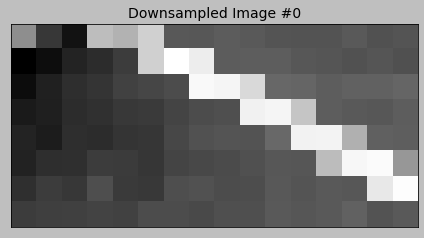

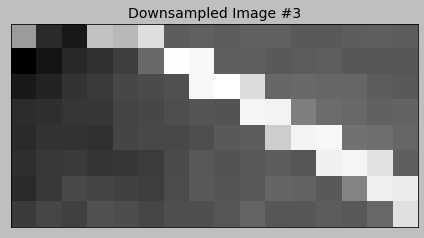

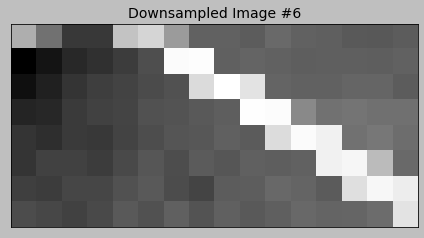

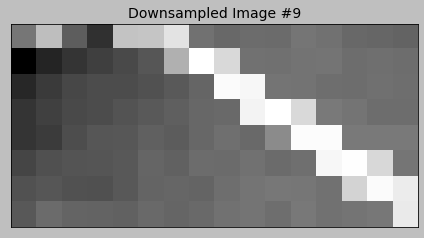

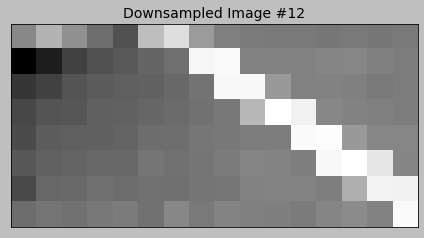

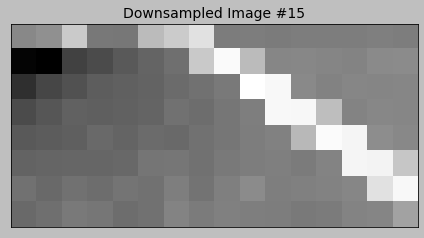

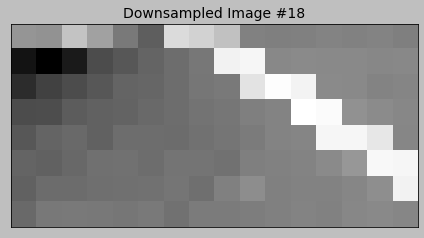

In [ ]:
print(sum(train_predictions))

invariants = get_all_invariants(basic_estimator)
describe_invariants_all_labels(invariants, None, layer, suffixes = train_suffixes, label = train_predictions)

In [ ]:
for _ in range(1000):
    plt.close()

In [ ]:
1+2